# Mixture Density Network (MDN)

The goal of this notebook is to test the implementation of Gaussian MDN in jax.

In [1]:
%load_ext autoreload

%autoreload 2

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.33"

import numpy as np
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import sbibm
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload
from typing import Sequence, Callable

import torch
import torch.utils.data as data

from normflow.utils import create_data_loader
from normflow.train import TrainerModule, TrainState

jax.config.update("jax_enable_x64", True)

2024-02-12 13:20:51.620800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 13:20:51.620870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 13:20:51.621710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 13:20:52.952346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Simulation model

In [2]:
sbibm.get_available_tasks()

['bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'gaussian_mixture',
 'lotka_volterra',
 'sir',
 'slcp',
 'two_moons',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [19]:
task = sbibm.get_task('slcp')
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0]
print(dim)

5


In [20]:
class SimulationDataset(data.Dataset):
    def __init__(self, num_points):
        super().__init__()
        self.thetas = prior(num_samples=num_points)
        self.xs = simulator(self.thetas)
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

In [21]:
train_set = SimulationDataset(20000)
val_set = SimulationDataset(2000)
test_set = SimulationDataset(5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train=[True, False, False],
    batch_size=128
)

/feynman/home/dap/lcs/sg276684/.conda/envs/jax_sbi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Neural posterior estimation using Gaussian MDN

In [6]:
%load_ext autoreload

%autoreload 2
from normflow.model import MixtureDensityNetwork
from normflow.distribution import MixtureDensityDistribution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
NF_mdn = MixtureDensityNetwork(
    n_data=dim,
    n_components=3,
    layers=[128, 128],
    activation = jax.nn.silu
)

In [12]:
seed = jax.random.PRNGKey(0)
seed, init_seed = jax.random.split(seed)

params = NF_mdn.init(seed, jnp.zeros((1, dim)))

In [13]:
key = jax.random.PRNGKey(42)

batch_size = 54

thetas = prior(num_samples=batch_size)
xs = simulator(thetas)
thetas, xs = jnp.array(thetas), jnp.array(xs)

NF_mdn.apply(params, xs).log_prob(thetas).shape

(54,)

In [17]:
key, subkey = jax.random.split(key)

samples = NF_mdn.apply(params, observation).sample(100000, seed=key)



In [18]:
samples.squeeze().shape

(100000, 2)

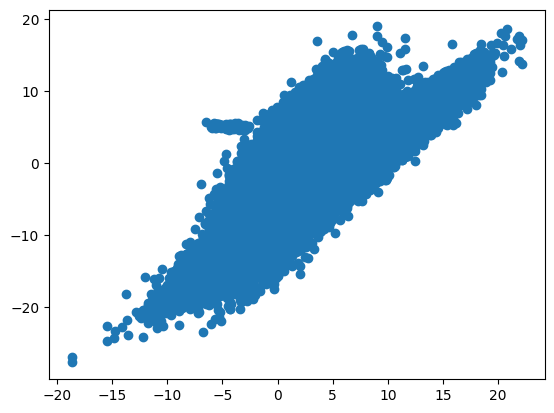

In [19]:
plt.figure()

plt.scatter(samples.squeeze()[:,0], samples.squeeze()[:, 1])
plt.show()

In [20]:
optimizer = optax.adam(learning_rate=1e-4)
opt_state = optimizer.init(params)

In [21]:
#negative log_likelihood
def loss_nll(params, mu, batch):
    return -jnp.mean(NF_mdn.apply(params, batch).log_prob(mu))

@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step"""
    loss, grads = jax.value_and_grad(loss_nll)(
        params, mu, batch
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [22]:
batch_size = 128
thetas = prior(num_samples=batch_size)
xs = simulator(thetas)

loss_nll(params, jnp.array(thetas), jnp.array(xs))

Array(11.52961, dtype=float32)

In [17]:
from tqdm import tqdm

batch_size = 128
batch_loss = []
pbar = tqdm(range(100000))

for batch in pbar:
    thetas = prior(num_samples=batch_size)
    xs = simulator(thetas)
    
    l, params, opt_state = update(
        params, opt_state, jnp.array(thetas, dtype=jnp.float64), jnp.array(xs, dtype=jnp.float64)
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")
    

  0%|          | 0/100000 [00:00<?, ?it/s]

loss 1.948: 100%|██████████| 100000/100000 [04:18<00:00, 386.23it/s]


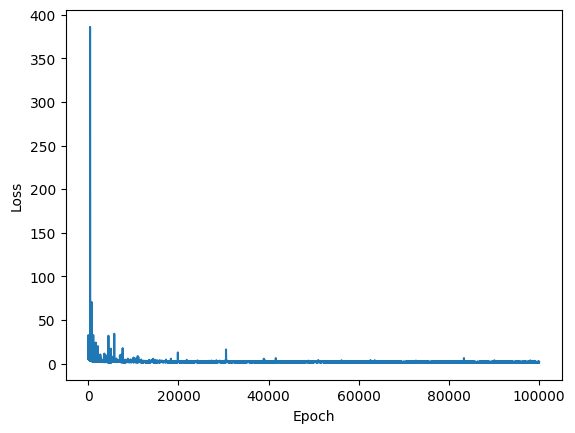

In [18]:
plt.figure()

plt.plot(batch_loss)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Results

In [19]:
from chainconsumer import ChainConsumer

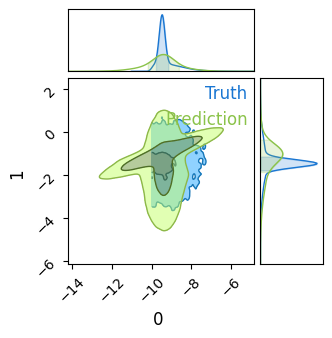

In [20]:
num_samples = 100000

sample_nd = NF_mdn.sample(
    params,
    y=observation,
    n_samples = num_samples,
    key = key
).squeeze()

key, subkey = jax.random.split(key)

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(sample_nd, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

In [21]:
np.exp(NF_mdn.md_model.apply(params, observation).mixture_distribution.logits)

array([[0.4306783 , 0.5330446 , 0.03627716]], dtype=float32)

## Using TrainerModule to train the Mixture Density Network

In [22]:
class MDNTrainer(TrainerModule):
    def __init__(self,
                 n_data : int,
                 n_components : int,
                 layers : Sequence[int],  
                 activation : Callable,
                 **kwargs):
        super().__init__(model_class=MixtureDensityNetwork,
                         model_hparams={
                            'n_data': n_data,
                            'n_components': n_components,
                            'layers': layers,
                            'activation': activation
                         },
                         **kwargs)
        
    def create_functions(self):
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, xs).log_prob(thetas))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step

    def print_tabulate(self, exmp_input):
        pass

    def generate_config(self, logger_params):
        super().generate_config(logger_params)
        sub_model_hparams = self.model_hparams.copy()
        sub_model_hparams['activation'] = sub_model_hparams['activation'].__name__
        self.config['model_hparams'] = sub_model_hparams
        


In [23]:
CHECKPOINT_PATH = '~/work/jax/notebooks/checkpoints/mdn'

trainer = MDNTrainer(n_data=dim,
                            n_components=5,
                            layers=[128, 128],
                            activation=jax.nn.silu,
                            optimizer_hparams={'lr': 4e-3},
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(train_loader))[1],
                            check_val_every_epoch=5)

In [24]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=50
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

In [25]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: 5.600544452667236
Validation loss: 6.007213592529297
Test loss: 6.017237186431885


In [26]:
model = trainer.bind_model()

In [27]:
key = jax.random.PRNGKey(42)

samples = model.apply({'params': trainer.state.params}, observation).sample(10000, key)

In [28]:
samples = samples.squeeze()

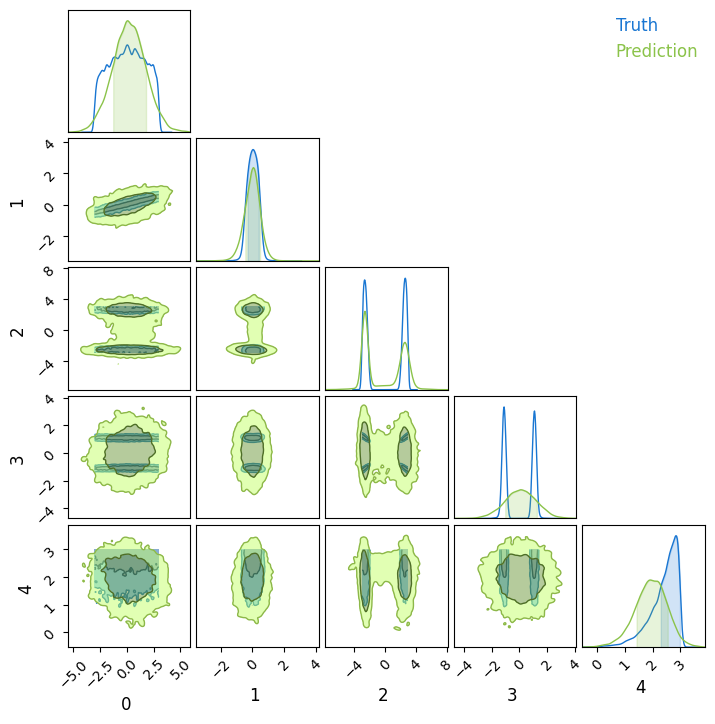

In [29]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()